998 2023-12-13_16-43-25
998 2023-12-13_16-46-43
998 [4.968376159667969, 4.974098205566406, 4.977882385253906, 4.984107971191406, 4.989158630371094, 4.9888458251953125, 4.995208740234375, 5.003120422363281, 5.0117950439453125, 5.015617370605469, 5.02923583984375, 5.038673400878906, 5.055877685546875, 5.066001892089844, 5.076576232910156, 5.1101837158203125, 5.151786804199219, 5.148200988769531, 5.143516540527344, 5.141319274902344, 5.26324462890625, 5.264747619628906, 5.243324279785156, 5.234352111816406, 5.219337463378906, 5.218170166015625, 5.242637634277344, 5.254905700683594, 5.26580810546875, 5.2622528076171875, 5.2688140869140625, 5.273475646972656, 5.2777099609375, 5.2823486328125, 5.291473388671875, 5.293357849121094, 5.293426513671875, 5.303764343261719, 5.3090667724609375, 5.3359527587890625, 5.355384826660156, 5.3493804931640625, 5.343879699707031, 5.334541320800781, 5.346160888671875, 5.339599609375, 5.349822998046875, 5.38116455078125, 5.39141845703125, 5.399375915527344, 5

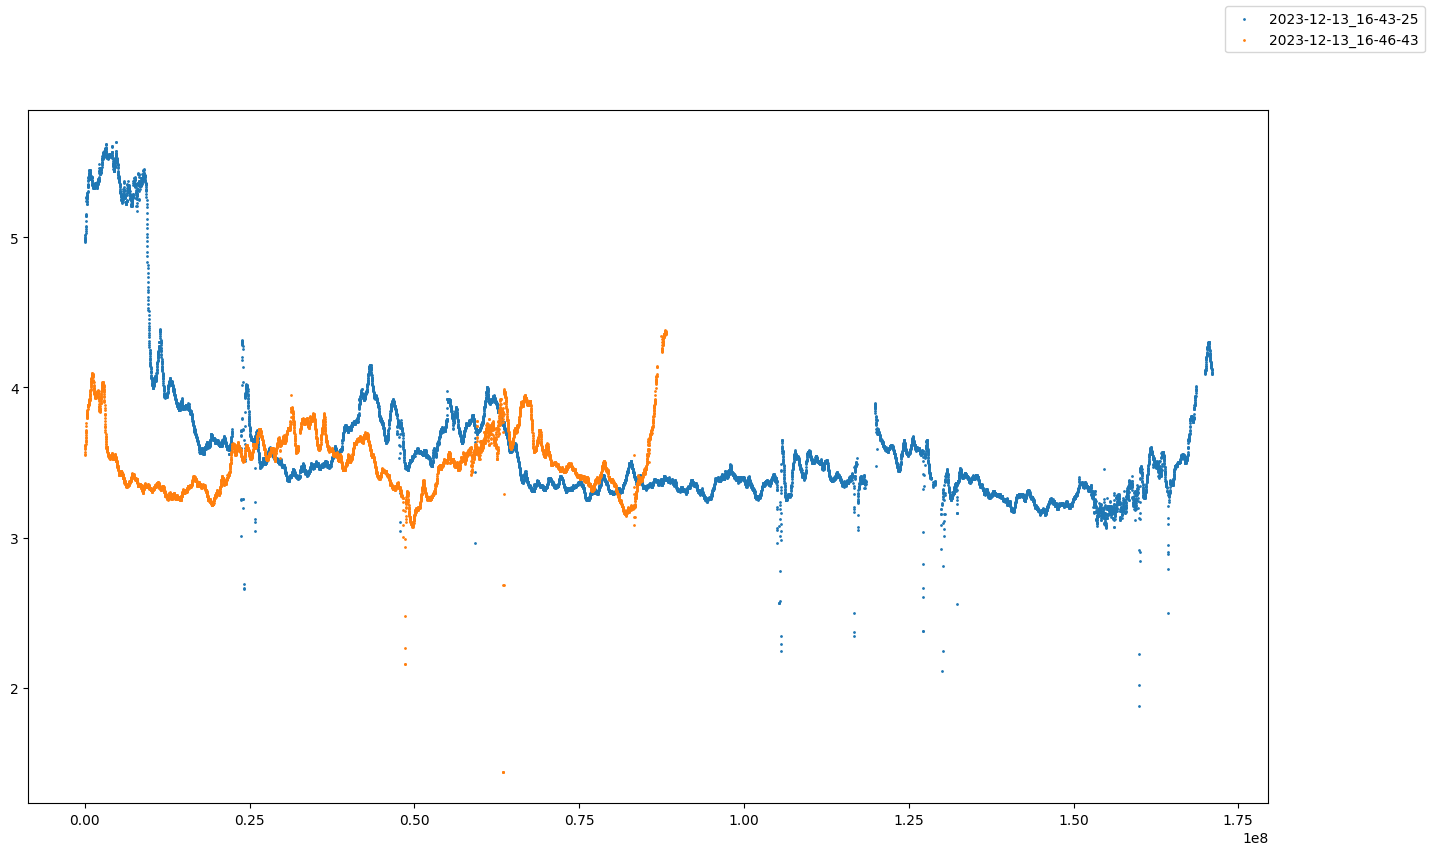

999 2023-12-13_16-40-22
999 2023-12-13_16-40-53
999 [3.5205841064453125, 3.505645751953125, 3.4844818115234375, 3.4773101806640625, 3.4666748046875, 3.4353408813476562, 3.4182052612304688, 3.3861236572265625, 3.365570068359375, 3.351470947265625, 3.3237457275390625, 3.29742431640625, 3.2851409912109375, 3.2541656494140625, 3.2219161987304688, 3.2096710205078125, 3.176605224609375, 3.1568450927734375, 3.1517486572265625, 3.1402053833007812, 3.1243820190429688, 3.1197128295898438, 3.1197891235351562, 3.1135101318359375, 3.1115264892578125, 3.1091842651367188, 3.0995559692382812, 3.0966262817382812, 3.0979080200195312, 3.1057586669921875, 3.105438232421875, 3.1057052612304688, 3.10205078125, 3.1000213623046875, 3.1079788208007812, 3.1135482788085938, 3.1224899291992188, 3.1281814575195312, 3.1397171020507812, 3.1403579711914062, 3.1506805419921875, 3.1627960205078125, 3.1737442016601562, 3.1863250732421875, 3.2112579345703125, 3.2245941162109375, 3.22955322265625, 3.2180099487304688, 3.21

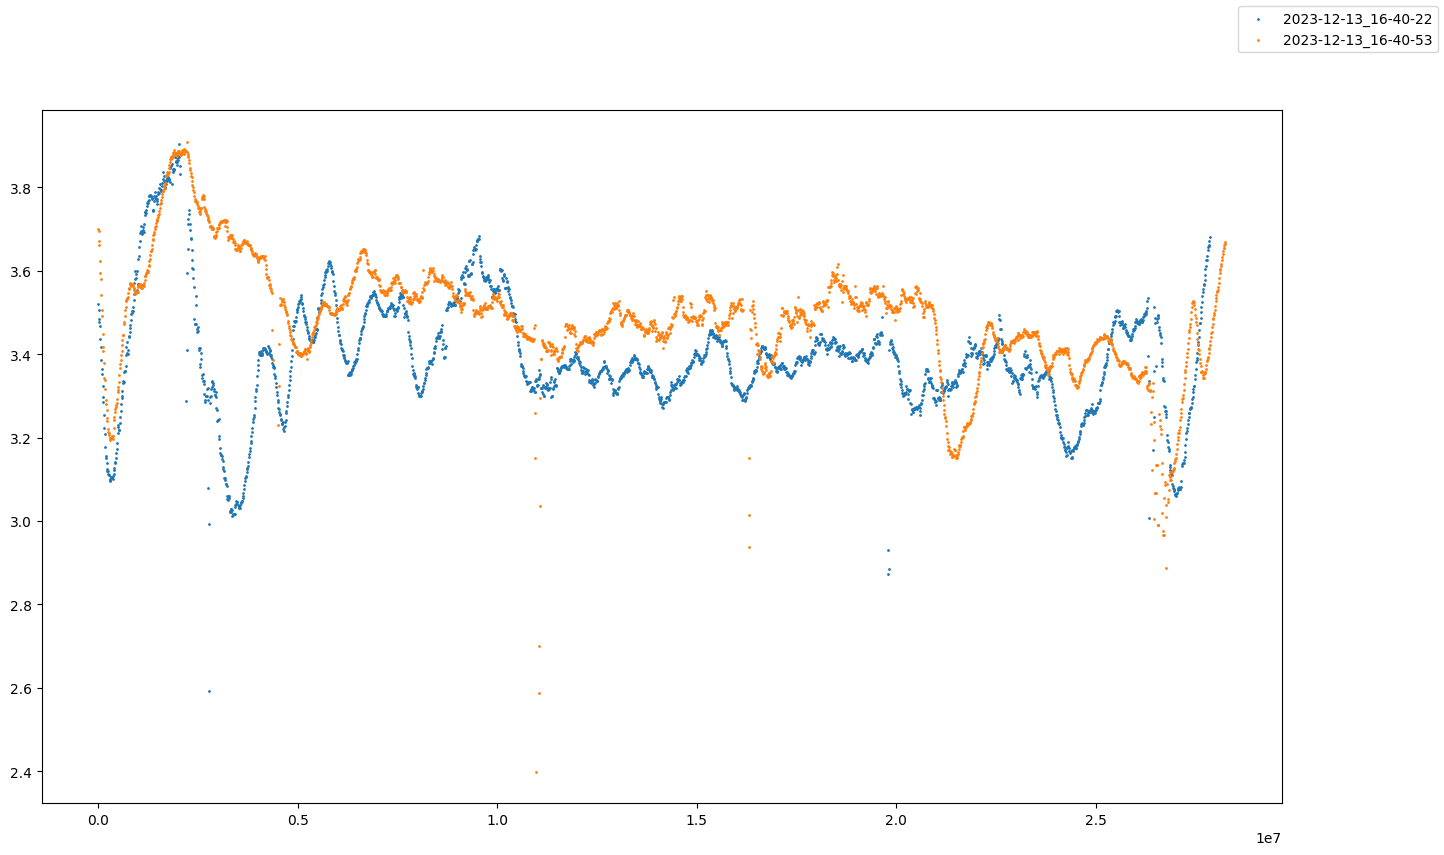

In [13]:
### Make a plot that shows the pupil size over time and average for first page and last page

from datetime import datetime
import os
from utils import Events
import matplotlib.pyplot as plt

EYE_TRACKER_FOLDER = "eye_tracker_data/"

participant_ids = [998, 999]

# Make sure y-axis starts at 0
# ax.set_ylim([0, 5])

for participant in participant_ids:
    fig, ax = plt.subplots(figsize=(16, 9))
    events = (
        Events.select()
        .where(Events.participant_id == participant)
        .where(Events.event.in_(["OPEN_BOOK", "CLOSE_BOOK"]))
        .order_by(Events.time)
    )

    batches = {}
    for event in events:
        if event.event == "OPEN_BOOK":
            timestamp_formatted = datetime.fromtimestamp(event.time / 1000).strftime(
                "%Y-%m-%d_%H-%M-%S"
            )

            gaze_data_filename = f"[{str(participant)}]-{timestamp_formatted}.json"
            gaze_data_filepath = os.path.join(EYE_TRACKER_FOLDER, gaze_data_filename)
            # Read the file
            import json

            with open(gaze_data_filepath, "r") as f:
                gaze_data = json.load(f)["data"]
                batches[timestamp_formatted] = gaze_data

    for timestamp_formatted, batch in batches.items():
        ### TODO: Get only the data from the start_time to end_time

        # Do calculation (gaze["left_pupil_diameter"] + gaze["right_pupil_diameter"]) / 2
        # on every gaze point and be None safe
        pupil_sizes = [
            (gaze["left_pupil_diameter"] + gaze["right_pupil_diameter"]) / 2
            if gaze["left_pupil_diameter"] is not None
            and gaze["right_pupil_diameter"] is not None
            else None
            for gaze in batch
        ]

        time_data = [
            gaze["system_time_stamp"] - batch[0]["system_time_stamp"]
            for gaze in batch
        ]

        ax.scatter(time_data, pupil_sizes, label=timestamp_formatted, s=1)

    fig.legend()
    plt.show()